This tutorial highlights the [HyRiver](https://github.com/hyriver/hyriver.github.io)software stack for Python, which is a very powerful tool for acquiring large sets of data from various web services. 

# HyRiver Introduction
The [HyRiver](https://github.com/hyriver/hyriver.github.io) software suite was developed by [Taher Chegini](https://github.com/cheginit) who, in their own words, describes HyRiver as:

>"... a software stack consisting of seven Python libraries that are designed to aid in hydroclimate analysis through web services."

This description does not do justice to the capability of this software. Through my research I have spent significant amounts of time wrangling various datasets - making sure that dates align, or accounting for spatial misalignment of available data. The HyRiver suite streamlines this process, and makes acquistion of different data from various sources much more efficient. 

Here, I am going walk through a demonstration of how to easily access large amounts of data (streamflow, geophysical, and meteorological) for a basin of interest. 

Before going through the code, I will highlight the three libraries from the HyRiver stack which I have found most useful: `PyGeoHydro`, `PyNHD`, and `PyDaymet`.

### PyGeohydro
[`PyGeoHydro`](https://github.com/hyriver/pygeohydro) allows for interaction with eight different online datasets, including: 
* [USGS National Water Information System (NWIS)](https://nwis.waterdata.usgs.gov/nwis)
* [NCAR Catchment Attributes and Meteorology for Large-sample Studies (CAMELS)](https://ral.ucar.edu/solutions/products/camels)
* [USGS Water Quality Portal](https://www.waterqualitydata.us/)
* [US ACE National Invetory of Dams (NID)](https://nid.sec.usace.army.mil/#/)

In this tutorial, I will only be interacting with the USGS NWIS, which provides daily streamflow data. 

### PyNHD
The [`PyNHD`](https://github.com/hyriver/pynhd) library is designed to interact with the [National Hydrography Dataset (NHD)](https://www.usgs.gov/national-hydrography/national-hydrography-dataset)and the [Hydro Network-Linked Data Index (NLDI)](https://labs.waterdata.usgs.gov/about-nldi/index.html).

#### NHDPlus (National Hydrography Dataset)
The NHD defines a high-resolutioon network of stream linkages, each with a unique idenfier (ComID).  

#### NLDI (Network-Linked Data Index)
The NLDI aids in the discovery of indexed information along some NHD-specified geometry (ComIDs). The NLDI essentially tranverses the linkages specified by the NHD geometry and generates data either local or basin-aggregated data relative to a specific linkage (ComID).

As will be seen later in the tutorial, the NLDI is able to retrieve atleast 126 different types of data for a given basin...

### PyDaymet
The [PyDaymet GirHub repository](https://github.com/hyriver/pydaymet) summarizes the package as:

>"\[providing] access to climate data from Daymet V4 database using NetCDF Subset Service (NCSS). Both single pixel (using `get_bycoords` function) and gridded data (using `get_bygeom`) are supported which are returned as pandas.DataFrame and xarray.Dataset, respectively."


## Tutorial outline:
0. Installation
1. Retrieving USGS Water Data
2. Retrieving Geophysical (NLDI) Data
2. Retrieving Daymet Data

[The HyRiver repository](https://github.com/hyriver/hyriver.github.io) contains various examples demonstrating the use of the various libraries. I would definitely recommend digging in deeper to these, and other [HyRiver](https://github.com/hyriver/hyriver.github.io) documentation if this post piques your interest.  


# Step 0: Installation

In this tutorial, I only only interact with the `PyNHD`, `PyGeoHydro`, and `PyDaymet` libraries, so I do not need to install all of the HyRiver suite. 

If you operate through `pip`, you can install these libraries using:

> `pip install pynhd pygeohydro pydaymet`

If you use Anaconda package manager, you can install these packages using:

> `conda install -c conda-forge pynhd pygeohydro pydaymet`

For more information on installation, refer to the [HyRiver GitHub repository](https://github.com/hyriver/hyriver.github.io) and related documentation.

Now, onto the fun part!

# Step 1: Retreiving USGS Water Data

I am beginning here because streamflow data is typically the first point of interest for most hydrologic engineers or modelers. 

Personally, I have gone through the process of trying to download data manually from the USGS NWIS website... My appreciation for the USGS prevents me from saying anything too negative, but let's just say it was not a pleasant experience. 

`Pygeohydro` allows for direct requests from the [USGS National Water Information System (NWIS)](https://waterdata.usgs.gov/nwis), which provides daily streamflow data from all USGS gages. The data is conveniently output as a Pandas DataFrame.

In this respect, the `PyGeoHydro` library alone is gamechanger. 

## 1.1 Initialize PyGeoHydro NWIS

In [1]:
# Import common libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Import the PyGeohydro libaray tools
import pygeohydro as gh
from pygeohydro import NWIS, plot

In [2]:
# Use the national water info system (NWIS)
nwis = NWIS()

## 1.2 Requesting USGS Streamflow Data

The `get_streamflow()` function does exactly as the name entails and will retrieve daily streamflow timeseries, however USGS gage station IDs must be provided. If you are only interested in a single location, then you can enter 8-digit gage ID number along with a specified date range to generate the data: 

`get_streamflow('########', dates = ('Y-M-D', 'Y-M-D'))`

However, I am want to explore larger sets of data over an entire region. Thus, I am going to use `PyGeoHydro's` `get_info()` function to identify all gages within some region of interest. 

First, I specify a `region` via (latitude, longitude) bounds, then I send a `query` which retrieves meta-data information on all the gages in the specified region.  In this case, I am exploring the data available near Ithaca, NY. 

In [8]:
# Query specifications
region = (-76.7, 42.3, -76, 42.6)  # Ithaca, NY

# Send a query for all gage info in the region
query = {"bBox": ",".join(f"{b:.06f}" for b in region),
         "hasDataTypeCd": "dv",
         "outputDataTypeCd": "dv"}

info_box = nwis.get_info(query)

print(f'PyGeoHydro found {len(set(info_box.site_no))} unique gages in this region.')

PyGeoHydro found 27 unique gages in this region.


Although, this info_box identify many gages in the region which have very old or very brief data records. Knowing this, I want to filter out data which does not have a suitable record length.

For the sake of this tutorial, I am considering data between January 1st, 2020 and December 31st, 2020.

In [9]:
# Specify date range of interest
dates = ("2020-01-01", "2020-12-31") 

# Filter stations to have only those with proper dates
stations = info_box[(info_box.begin_date <= dates[0]) & (info_box.end_date >= dates[1])].site_no.tolist()

# Remove duplicates by converting to a set
stations = list(set(stations))

print(f'Great, the NWIS found {len(stations)} stations which have data between {dates[0]} and {dates[1]}.')

Great, the NWIS found 17 stations which have data between 2020-01-01 and 2020-12-31.


Now, I am ready to use the gage IDs contained in stations to request the streamflow data!

In [10]:
# Retrieve the flow data
flow_data = nwis.get_streamflow(stations, dates, mmd=False)

# Remove gages with nans
flow_data = flow_data.dropna(axis = 1, how = 'any')

Dropped 1 stations since they don't have discharge data from 2020-01-01 to 2020-12-31.


After removing duplicates and gages with nans, I have data from five unique gages in this region.

Additionally, PyGeoHydro has a convenient plotting feature to help quickly visualize the streamflow data.

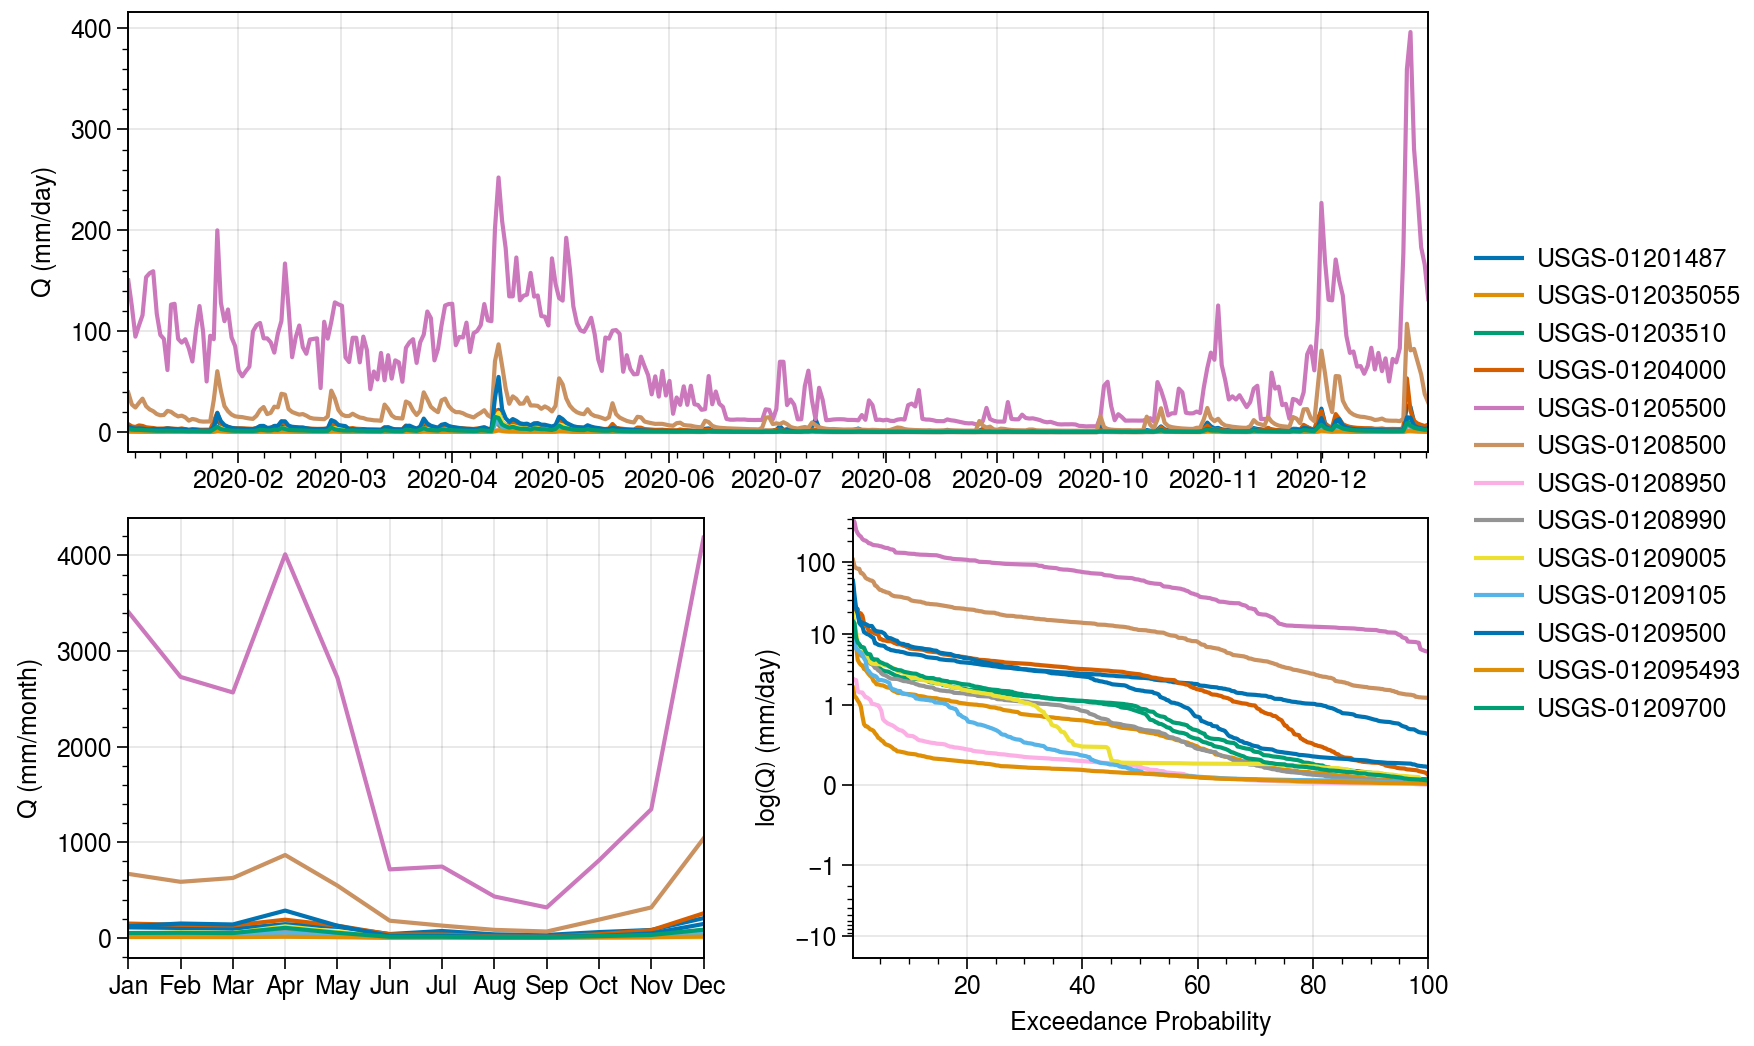

In [12]:
# Plot flow data summary
plot.signatures(flow_data)

There is a lot more to be explored in the PyGeoHydro library, but I will leave that up to the curious reader.  

# Step 2: Retrieving Geophysical (NLDI) Data

So, you've got some streamflow data but you don't know anything about the physical watershed…

This is where the PyNHD library comes in. Using this library, I can identify entire upstream network from a gage, then extract the NLDI data associated with the watershed linkages.

So, you've got some streamflow data but you don't know anything about the physical watershed...

This is where the `PyNHD` library comes in.  Using this library, I can identify entire upstream network from a gage, then extract the NLDI data associated with the watershed linkages. 


In [ ]:
# Import the PyNHD library
import pynhd as pynhd
from pynhd import NHD
from pynhd import NLDI, WaterData

In [103]:
# Initialize NLDI server
nldi = NLDI()

First, we can take a look at all possible basin characteristic data that are available: 

In [108]:
# Get list of local data types (AKA characteristics, or attributes)
possible_attributes = nldi.get_validchars("local").index.to_list()

print(f'There are {len(possible_attributes)} available from NLDI!')

There are 126 available from NLDI!


There are **126 characteristics available from the NLDI!** These characteristics range from elevation, to reservoir capacity, to bedrock depth. Many if these are not of immediate interest to me, so I will specify a subset of `select_attributes` to retrieve (basin area, max elevation, and stream slope). 

I then loop through all of my USGS stations for which I have data in `flow_data`, identifying the upstream basin linkages using `NLDI().navigate_byid()`.  Once the basin is identified, I extract the `ComID` numbers for each linkage and use that number to retrieve the NLDI data of interest. I then store the data in `nldi_data`.  This process is done by the following: 

In [106]:
# Specify characteristics of interest
select_attributes = ['CAT_BASIN_AREA', 'CAT_ELEV_MAX', 'CAT_STREAM_SLOPE']

# Initialize a storage matrix
n_phys_params = len(select_attributes)
nldi_data = np.zeros((len(flow_data.columns), n_phys_params))

In [107]:
# Loop through all gages, and request NLDI data near each gage
for i, st in enumerate(flow_data.columns):

    # Navigate up flowlines from gage
    main_flows = nldi.navigate_byid(fsource = 'nwissite',
                                    fid = f'{st}',
                                    navigation="upstreamTributaries",
                                    source = 'flowlines',
                                    distance = 10)

    # Get the nearest comid
    station_comid = main_flows.nhdplus_comid.to_list()[0]

    # Source NLDI local data
    nldi_data[i,:] = nldi.getcharacteristic_byid(station_comid, "local", char_ids = select_attributes)

    
print(f'Geophyscial data found! \nWe retrieved {nldi_data.shape[1]} attributes for {nldi_data.shape[0]} station locations.')

Geophyscial data found! 
We retrieved 3 attributes for 72 station locations.


So far, I have timeseries streamflow data for five locations in the Ithaca, NY area, along with the basin area, max basin elevation, and stream slope for each stream.  If I can access hydro-climate data, maybe I could begin studying the relationships between streamflow and physical basin features after some rain event.  

# Step 3: Meteorological data

The [`PyDaymet`]() library allows for direct requests of meteorological data across an entire basin. 

The available data includes:
* Minimum and maximum temperature (`tmin`, `tmax`)
* Precipitation (`prcp`)
* Vapor pressure (`vp`)
* Snow-Water Equivalent (`swe`)
* Shortwave radiation (`srad`)

All data are reported daily at a 1km x 1km resolution. Additionally, the `PyDaymet` library has the ability to estimate potential evapotranspiration, using various approximation methods.

Here, I choose to only request precipitation (`prcp`) and max temperature (`tmax`). 

> **NOTE:**
> So far, the Daymet data retrieval process has been the slowest aspect of my HyRiver workflow. Due to the high-resolution, and potential for large basins, this may be computationally over-intensive if you try to request data for many gages with long time ranges. 


In [111]:
# Import the  PyDayment library
import pydaymet as daymet

In [113]:
## Specify which data to request
met_vars = ["prcp", "tmax"]
met_data_names = np.array(['mean_prcp','sd_prcp','mean_tmax','sd_tmax'])

## Initialize storage
daymet_data = np.zeros((len(flow_data.columns), len(met_data_names)))

Similar to the NLDI() process, I loop through each gage (flow_data.columns) and (1) identify the up-gage basin, (2) source the Daymet data within the basin, (3) aggregate and store the data in daymet_data.

In [114]:
## Loop through stations from above
for i, st in enumerate(flow_data.columns):

    # Get the up-station basin geometry
    geometry = NLDI().get_basins(st).geometry[0]

    # Source Daymet data within basin
    basin_met_data = daymet.get_bygeom(geometry, dates, variables= met_vars)

    ## Pull values, aggregate, and store
    # Mean and std dev precipitation
    daymet_data[i, 0] = np.nan_to_num(basin_met_data.prcp.values).mean()
    daymet_data[i, 1] = np.nan_to_num(basin_met_data.prcp.values).std()

    # Mean and std dev of max temperature
    daymet_data[i, 2] = np.nan_to_num(basin_met_data.tmax.values).mean()
    daymet_data[i, 3] = np.nan_to_num(basin_met_data.tmax.values).std()

daymet_data.shape

KeyboardInterrupt: 

Without having used a web-browsers, I have been able to get access to a set of physical basin characteristics, various climate data, and observed streamflow relevant to my region of interest!

# Conclusion

I hope this introduction to HyRiver has encouraged you to go bigger with your hydroclimate data ambitions. 

If you are curious to learn more, I'd recommend you see the HyRiver Examples which have various in-depth Jupyter Notebook tutorials. 

# Citations

Chegini, Taher, et al. “HyRiver: Hydroclimate Data Retriever.” Journal of Open Source Software, vol. 6, no. 66, 27 Oct. 2021, p. 3175, 10.21105/joss.03175. Accessed 15 June 2022.